In [1]:
!nvidia-smi

Sat Mar 19 19:02:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
| 42%   48C    P0    43W / 180W |    981MiB /  8192MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!pip install pynvml
!python rapidsai-csp-utils/colab/env-check.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.


***********************************************************************
Woo! Your instance has the right kind of GPU, a NVIDIA GeForce GTX 1070 Ti!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [1]:
#Import the libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Download and Unzip the dataset.

In [2]:
# url_to_the_zip_file = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/34330/3265183/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1647437599&Signature=qVPxXAvAiFlZLpO%2Fp287NXm%2FlUOymBxRMs7NJKMGXlm3afW9PV9LuNalMJS56E%2BjsMSHh46ouLS6gNHYbyPwmdLSQiPpLQPGU6NTKTNprbDUOgYb2rqC4w6AgLOpdRh%2FGdabYAVAdjIh24Teoj5k%2Bs%2Fybm00sxAGf358%2BcxjEonvvUJDEhK7GTtv9NAFxAfsO%2F69xOWSkLEhjjnCwQ3QzfXWxbuYVnqlwy0dwQ6S%2F8iQappRaQg2%2BF9j76t1ay0B3Kg3ANj0P5EuVMDL2KVld3cQLiM7DPi9vQQV531T8snYsbiHjoE%2BhkH6w%2BWeULvu5UpDSaiVRepgtoscjgM8ig%3D%3D&response-content-disposition=attachment%3B+filename%3D2110446-data-science-and-data-engineering-2022.zip"
# new_file_name = "2110446-data-science-and-data-engineering-2022.zip"

# !rm -f "$new_file_name"
# !wget -c "$url_to_the_zip_file" -O "$new_file_name"
# !unzip "$new_file_name"

## read_csv()

In [3]:
def toDF(pm25_filename, temp_filename, wind_filename):
  pm25_df = pd.read_csv('datasci_dataset_2022/'+pm25_filename, names=['Time', 'PM25'], skiprows=1)
  pm25_df['Time'] = pd.to_datetime(pm25_df['Time'])
  # pm25_df['Time'] = pm25_df['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
  # pm25_df['Time'] = pm25_df['Time'].dt.tz_localize(None)
  pm25_df.set_index('Time', inplace=True)
  pm25_df.columns = ['PM25']
  pm25_df = pm25_df[~pm25_df.index.duplicated(keep='first')]
  pm25_df.interpolate(inplace=True)
  pm25_df.index = pd.DatetimeIndex(pm25_df.index)

  temp_df = pd.read_csv('datasci_dataset_2022/'+temp_filename, names=['Time', 'Temp'], skiprows=1)
  temp_df['Time'] = pd.to_datetime(temp_df['Time'])
  temp_df.set_index(temp_df['Time'], inplace=True)
  temp_df.drop(columns={'Time'}, inplace=True)
  temp_df.columns = ['Temp']
  # pad() is similar to fillna() with forward filling
  temp_df = temp_df.resample('h').pad()
  # temp_df.index = pd.DatetimeIndex(temp_df.index)

  wind_df = pd.read_csv('datasci_dataset_2022/'+wind_filename, names=['Time', 'WindSpeed', 'WindDir'], skiprows=1)
  wind_df['Time'] = pd.to_datetime(wind_df['Time'])
  wind_df.set_index(wind_df['Time'], inplace=True)
  wind_df.drop(columns={'Time'}, inplace=True)
  wind_df.columns = ['WindSpeed', 'WindDir']
  # backward filling
  wind_df = wind_df.resample('h').bfill()
  # wind_df.index = pd.DatetimeIndex(wind_df.index)

  pm25_df['copy_index'] = pm25_df.index
  df = pd.merge(pm25_df, temp_df, left_index=True, right_index=True)
  df = pd.merge(df, wind_df, left_index=True, right_index=True)

  df = df[['Temp','WindSpeed','WindDir','PM25']]
  
  # padding first and last indices
  # df = df.ffill()
  # df = df.bfill()

  return df

In [4]:
def toDFtest(pm25_filename, temp_filename, wind_filename):
  pm25_df = pd.read_csv('datasci_dataset_2022/'+pm25_filename, names=['Time', 'PM25'], skiprows=1)
  pm25_df['Time'] = pd.to_datetime(pm25_df['Time'])
  pm25_df.set_index('Time', inplace=True)
  pm25_df.columns = ['PM25']
  pm25_df = pm25_df[~pm25_df.index.duplicated(keep='first')]
  pm25_df.index = pd.DatetimeIndex(pm25_df.index)

  temp_df = pd.read_csv('datasci_dataset_2022/'+temp_filename, names=['Time', 'Temp'], skiprows=1)
  temp_df['Time'] = pd.to_datetime(temp_df['Time'])
  temp_df.set_index(temp_df['Time'], inplace=True)
  temp_df.drop(columns={'Time'}, inplace=True)
  temp_df.columns = ['Temp']
  temp_df = temp_df.resample('h').bfill()

  wind_df = pd.read_csv('datasci_dataset_2022/'+wind_filename, names=['Time', 'WindSpeed', 'WindDir'], skiprows=1)
  wind_df['Time'] = pd.to_datetime(wind_df['Time'])
  wind_df.set_index(wind_df['Time'], inplace=True)
  wind_df.drop(columns={'Time'}, inplace=True)
  wind_df.columns = ['WindSpeed', 'WindDir']
  # backward filling
  wind_df = wind_df.resample('h').bfill()
  # wind_df.index = pd.DatetimeIndex(wind_df.index)

  pm25_df['copy_index'] = pm25_df.index
  df = pd.merge(pm25_df, temp_df, left_index=True, right_index=True)
  df = pd.merge(df, wind_df, left_index=True, right_index=True)

  df = df[['Temp','WindSpeed','WindDir','PM25']]

  return df

In [5]:
bkk_train = toDF('BKK/train/bkk_train.csv', 'BKK/train/bkk_temp_surface.csv', 'BKK/train/bkk_weather_wind.csv')
bkk_test = toDF('BKK/test/bkk_test.csv', 'BKK/test/bkk_temp_test.csv', 'BKK/test/bkk_wind_test.csv')

cnx_train = toDF('Chiangmai/train/chiangmai_train.csv', 'Chiangmai/train/chiangmai_temp_surface.csv', 'Chiangmai/train/chiangmai_weather_wind.csv')
cnx_test = toDF('Chiangmai/test/chiangmai_test.csv', 'Chiangmai/test/chiangmai_temp_test.csv', 'Chiangmai/test/chiangmai_wind_test.csv')

kkc_train = toDF('Khonkaen/train/khonkhan_train.csv', 'Khonkaen/train/khonkaen_temp_surface.csv', 'Khonkaen/train/khonkaen_weather_wind.csv')
kkc_test = toDF('Khonkaen/test/khonkhan_test.csv', 'Khonkaen/test/khonkaen_temp_test.csv', 'Khonkaen/test/khonkaen_wind_test.csv')

rayong_train = toDF('Rayong/train/rayong_train.csv', 'Rayong/train/rayong_temp_surface.csv', 'Rayong/train/rayong_weather_wind.csv')
rayong_test = toDF('Rayong/test/rayong_test.csv', 'Rayong/test/rayong_temp_test.csv', 'Rayong/test/rayong_wind_test.csv')

saraburi_train = toDF('Saraburi/train/saraburi_train.csv', 'Saraburi/train/saraburi_temp_surface.csv', 'Saraburi/train/saraburi_weather_wind.csv')
saraburi_test = toDF('Saraburi/test/saraburi_test.csv', 'Saraburi/test/saraburi_temp_test.csv', 'Saraburi/test/saraburi_wind_test.csv')

surat_train = toDF('Surat/train/surat_train.csv', 'Surat/train/surat_temp_surface.csv', 'Surat/train/surat_weather_wind.csv')
surat_test = toDF('Surat/test/surat_test.csv', 'Surat/test/surat_temp_test.csv', 'Surat/test/surat_wind_test.csv')

In [6]:
train_set={}
train_set['BKK'] = bkk_train
train_set['CNX'] = cnx_train
train_set['KKC'] = kkc_train
train_set['RAY'] = rayong_train
train_set['SARA'] = saraburi_train
train_set['SURAT'] = surat_train

test_set={}
test_set['BKK'] = bkk_test
test_set['CNX'] = cnx_test
test_set['KKC'] = kkc_test
test_set['RAY'] = rayong_test
test_set['SARA'] = saraburi_test
test_set['SURAT'] = surat_test

## Number of null values

### Before Dropping

In [7]:
null_counts_bkk_train = bkk_train.isnull().sum()
print("[bkk_train] Number of null values in each column:\n{}".format(null_counts_bkk_train))
print('\n')

null_counts_cnx_train = cnx_train.isnull().sum()
print("[cnx_train] Number of null values in each column:\n{}".format(null_counts_cnx_train))
print('\n')

null_counts_kkc_train = kkc_train.isnull().sum()
print("[kkc_train] Number of null values in each column:\n{}".format(null_counts_kkc_train))
print('\n')

null_counts_rayong_train = rayong_train.isnull().sum()
print("[rayong_train] Number of null values in each column:\n{}".format(null_counts_rayong_train))
print('\n')

null_counts_saraburi_train = saraburi_train.isnull().sum()
print("[saraburi_train] Number of null values in each column:\n{}".format(null_counts_saraburi_train))
print('\n')

null_counts_surat_train = surat_train.isnull().sum()
print("[surat_train] Number of null values in each column:\n{}".format(null_counts_surat_train))

[bkk_train] Number of null values in each column:
Temp         3
WindSpeed    0
WindDir      0
PM25         0
dtype: int64


[cnx_train] Number of null values in each column:
Temp         6
WindSpeed    0
WindDir      0
PM25         0
dtype: int64


[kkc_train] Number of null values in each column:
Temp         0
WindSpeed    0
WindDir      0
PM25         0
dtype: int64


[rayong_train] Number of null values in each column:
Temp         0
WindSpeed    0
WindDir      0
PM25         0
dtype: int64


[saraburi_train] Number of null values in each column:
Temp         0
WindSpeed    0
WindDir      0
PM25         0
dtype: int64


[surat_train] Number of null values in each column:
Temp         126
WindSpeed      0
WindDir        0
PM25           0
dtype: int64


### Drop null-valued rows (Temp & PM25)

In [8]:
bkk_train.dropna(subset=['Temp','PM25'], inplace=True)

cnx_train.dropna(subset=['Temp','PM25'], inplace=True)

kkc_train.dropna(subset=['Temp','PM25'], inplace=True)

rayong_train.dropna(subset=['Temp','PM25'], inplace=True)

saraburi_train.dropna(subset=['Temp','PM25'], inplace=True)

surat_train.dropna(subset=['Temp','PM25'], inplace=True)

## Graph Plotting

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis, skew

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

In [10]:
def multiDisplot(dataset, col, hist=False, xlim=None):
  for prov, _ in dataset.items():
    sns.distplot(dataset[prov][col], hist=hist, label=prov)
    # print(f"{prov} {col}={dataset[prov][col].mean()}")
  plt.xlim(xlim)
  plt.legend()
  plt.show()

In [11]:
# multiDisplot(train_set, 'PM25', xlim=(-10, 120), hist=True)

In [12]:
# multiDisplot(train_set, 'Temp', hist=True)

In [13]:
# multiDisplot(train_set, 'WindDir', hist=True)

In [14]:
# multiDisplot(train_set, 'WindSpeed', hist=True)

## Handle outliers

In [15]:
class Handle_Outliers:
  def __init__(self, dataset):
    self.dataset=dataset.copy()
    self.dataShape={}

    for prov, dfcol in dataset.items():
      self.dataShape[prov] = {}
      for col, _ in dfcol.items():
        self.dataShape[prov][col] = {'Kurt':{}, 'Skew':{}}
   
  def plotIQR(self, province, col, title="", thresh=None, fig=None, subplots=None, figsize=None):
    dataset = self.dataset

    if subplots is None: subplots = [211, 212]
    if figsize is None: figsize = (10,8)


    if fig is not None:
      rows = subplots[0]//100
      cols = (subplots[0]%100)//10
      fig.add_subplot(rows, cols, subplots[0]%10)
    else:
      plt.figure(figsize=figsize)
      plt.subplot(subplots[0])

    plt.title(title)
    plt.xlim(dataset[province][col].min()/1.1, dataset[province][col].max()*1.1)
    if thresh:
      plt.axvline(x=thresh[province]['min'])
      plt.axvline(x=thresh[province]['max'])

    ax = dataset[province][col].plot(kind='kde')

    if fig is not None:
      rows = subplots[1]//100
      cols = (subplots[1]%100)//10
      fig.add_subplot(rows, cols, subplots[1]%10)
    else:
      plt.figure(figsize=figsize)
      plt.subplot(subplots[1])
      
    plt.xlim(dataset[province][col].min()/1.1, dataset[province][col].max()*1.1)
    sns.boxplot(x=dataset[province][col])

    if thresh is not None:
      plt.axvline(x=thresh[province]['min'])
      plt.axvline(x=thresh[province]['max'])

    if subplots is None:
      plt.show()

  def calcDataShape(self, province, col, verbose=0, save_slot=None):
    dataset = self.dataset

    kurtosis_value = kurtosis(dataset[province][col])
    skew_value = skew(dataset[province][col])

    if (verbose>0):
      print("\n")
      print(f"kurtosis_value = {kurtosis_value}")
      print(f"skew_value = {skew_value}")

    if (save_slot is not None):
      self.saveDataShape(province, col, kurtosis_value, skew_value, save_slot)
  
  def showDataShape(self, province, col, save_slot=None):
    dataShape = self.dataShape

    if (save_slot is not None):
      kurtosis_value = dataShape[province][col]['Kurt'][save_slot]
      skew_value = dataShape[province][col]['Skew'][save_slot]
      print(f"{save_slot}:")
      print(f"kurtosis_value = {kurtosis_value}")
      print(f"skew_value = {skew_value}")
      print("\n")

    else:
      for sav_slot, _ in dataShape[province][col]['Kurt'].items():
        kurtosis_value = dataShape[province][col]['Kurt'][sav_slot]
        skew_value = dataShape[province][col]['Skew'][sav_slot]
        print(f"{sav_slot}:")
        print(f"kurtosis_value = {kurtosis_value}")
        print(f"skew_value = {skew_value}")
        print("\n")
  
  def saveDataShape(self, province, col, kurt, skew, save_slot):
    dataShape = self.dataShape

    dataShape[province][col]['Kurt'][save_slot] = kurt
    dataShape[province][col]['Skew'][save_slot] = skew
  
  def addColumns(self, col, new_col, func):
    dataset = self.dataset
    dataShape = self.dataShape

    for prov, _ in dataset.items():
      dataset[prov][new_col] = func(dataset[prov][col])
      dataShape[prov][new_col] = {'Kurt':{}, 'Skew':{}}
  
  def calcOutliersMinMax(self, province, col, C_std):
    dataset = self.dataset

    thresh_min = dataset[province][col].mean() - C_std*dataset[province][col].std()
    thresh_min = 0 if (thresh_min<0) else thresh_min

    thresh_max = dataset[province][col].mean() + C_std*dataset[province][col].std()
    
    return thresh_min, thresh_max
  
  def setOutliersThreshold(self, province, col, new_col, thresh):
    dataset = self.dataset

    min, max = thresh[province]['min'], thresh[province]['max']

    dataset[province][new_col] = dataset[province][col]

    dataset[province].loc[dataset[province][new_col]<min, new_col] = min
    dataset[province].loc[dataset[province][new_col]>max, new_col] = max

### Using IQR to detect outliers

In [16]:
handle_outliers = Handle_Outliers(train_set)

#### Before Log

In [17]:
# handle_outliers.plotIQR('BKK', 'PM25', 'Bangkok_Train PM2.5')
# handle_outliers.calcDataShape('BKK', 'PM25', save_slot='Before')

In [18]:
# handle_outliers.plotIQR('CNX', 'PM25', "Chiangmai_Train PM2.5")
# handle_outliers.calcDataShape('CNX', 'PM25', save_slot='Before')

In [19]:
# handle_outliers.plotIQR('KKC', 'PM25', "Khonkaen_Train PM2.5")
# handle_outliers.calcDataShape('KKC', 'PM25', save_slot='Before')

In [20]:
# handle_outliers.plotIQR('RAY', 'PM25', "Rayong_Train PM2.5")
# handle_outliers.calcDataShape('RAY', 'PM25', save_slot='Before')

In [21]:
# handle_outliers.plotIQR("SARA", 'PM25', "Saraburi_Train PM2.5")
# handle_outliers.calcDataShape("SARA", 'PM25', save_slot='Before')

In [22]:
# handle_outliers.plotIQR('SURAT', 'PM25', "Surat_Train PM2.5")
# handle_outliers.calcDataShape('SURAT', 'PM25', save_slot='Before')

#### After Log

In [23]:
handle_outliers.addColumns('PM25', 'Log_PM25', lambda x: np.log(1+x))

In [24]:
# handle_outliers.plotIQR('BKK', 'Log_PM25', "Bangkok_Train Log(PM2.5)")
# handle_outliers.calcDataShape('BKK', 'Log_PM25', save_slot='After')

In [25]:
# handle_outliers.plotIQR('CNX', 'Log_PM25', "Chiangmai_Train Log(PM2.5)")
# handle_outliers.calcDataShape('CNX', 'Log_PM25', save_slot='After')

In [26]:
# handle_outliers.plotIQR('KKC', 'Log_PM25', "Khonkaen_Train Log(PM2.5)")
# handle_outliers.calcDataShape('KKC', 'Log_PM25', save_slot='After')

In [27]:
# handle_outliers.plotIQR('RAY', 'Log_PM25', "Rayong_Train Log(PM2.5)")
# handle_outliers.calcDataShape('RAY', 'Log_PM25', save_slot='After')

In [28]:
# handle_outliers.plotIQR('SARA', 'Log_PM25', "Saraburi_Train Log(PM2.5)")
# handle_outliers.calcDataShape('SARA', 'Log_PM25', save_slot='After')

In [29]:
# handle_outliers.plotIQR('SURAT', 'Log_PM25', "Surat_Train Log(PM2.5)")
# handle_outliers.calcDataShape('SURAT', 'Log_PM25', save_slot='After')

#### Set the outliers to min or max

In [30]:
# handle_outliers.showDataShape('BKK', 'PM25', 'Before')
# handle_outliers.showDataShape('BKK', 'Log_PM25')

In [31]:
train_set['BKK'].describe(include='all')

,Temp,WindSpeed,WindDir,PM25,Log_PM25
count,26299.000000,26299.000000,26299.000000,26299.000000,26299.000000
mean,29.810069,20.479410,167.592684,27.309441,3.217490
std,2.653087,13.030854,92.230443,15.368269,0.494102
min,17.200000,0.000000,0.000000,3.000000,1.386294
25%,28.000000,11.000000,80.000000,17.000000,2.890372
50%,29.600000,17.000000,155.000000,23.000000,3.178054
75%,31.600000,27.000000,260.000000,34.000000,3.555348
max,38.100000,85.000000,360.000000,130.000000,4.875197


In [32]:
thresh = {}

for prov, _ in train_set.items():
    thresh[prov] = {}
    thresh[prov]['min'], thresh[prov]['max'] = handle_outliers.calcOutliersMinMax(prov, 'Log_PM25', 3)
    handle_outliers.setOutliersThreshold(prov, 'Log_PM25', 'new_Log_PM25', thresh)

handle_outliers.addColumns('new_Log_PM25','new_PM25', lambda x: np.exp(x)-1)

##### Example 'Saraburi' : Boxplots of old and new PM2.5 after outlier handling

In [33]:
handle_outliers.dataset['SARA'].describe()

,Temp,WindSpeed,WindDir,PM25,Log_PM25,new_Log_PM25,new_PM25
count,26302.000000,26302.000000,26302.000000,26302.000000,26302.000000,26302.000000,26302.000000
mean,28.329245,21.015360,173.065546,33.852616,3.351286,3.354525,33.851236
std,4.062801,13.520995,83.727460,21.925800,0.671915,0.660619,21.777554
min,14.000000,0.000000,0.000000,1.000000,0.693147,1.335541,2.802054
25%,25.400000,11.000000,90.000000,18.000000,2.944439,2.944439,18.000000
50%,27.800000,18.000000,180.000000,29.000000,3.401197,3.401197,29.000000
75%,31.200000,28.000000,250.000000,44.000000,3.806662,3.806662,44.000000
max,40.900000,91.000000,360.000000,407.000000,6.011267,5.367030,213.225732


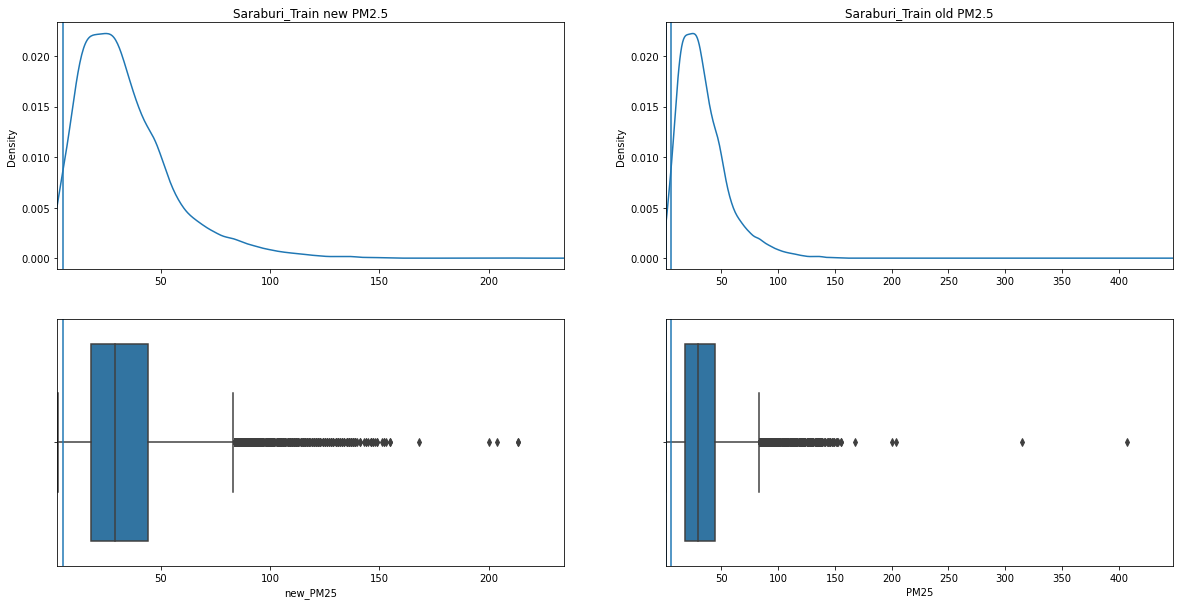

In [34]:
fig = plt.figure(figsize=(20,10))

handle_outliers.plotIQR('SARA', 'new_PM25', 'Saraburi_Train new PM2.5', thresh, fig=fig, subplots=[221, 223], figsize=(15,10))
handle_outliers.plotIQR('SARA', 'PM25', 'Saraburi_Train old PM2.5', thresh, fig=fig, subplots=[222, 224], figsize=(15,10))
plt.show()

## SARIMAX

In [95]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pickle

In [96]:
bkk_train_tmp = handle_outliers.dataset['BKK'][['new_PM25', 'Temp', 'WindSpeed', 'WindDir']]
bkk_train_tmp.rename(columns={'new_PM25':'PM25'}, inplace=True)

bkk_train_tmp = handle_outliers.dataset['BKK'][['new_PM25', 'Temp', 'WindSpeed', 'WindDir']]
bkk_train_tmp.rename(columns={'new_PM25':'PM25'}, inplace=True)


In [97]:
bkk_train_tmp.head()

,PM25,Temp,WindSpeed,WindDir
Time,,,,
2017-07-01 01:00:00,10.0,27.9,16,260
2017-07-01 02:00:00,17.0,27.9,16,255
2017-07-01 03:00:00,20.0,27.9,16,255
2017-07-01 04:00:00,15.0,27.4,16,255
2017-07-01 05:00:00,16.0,27.4,17,235


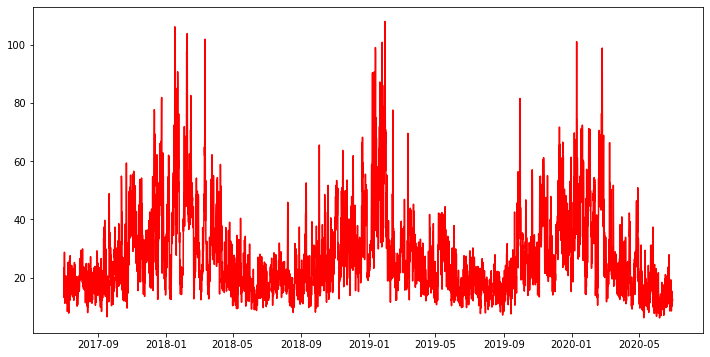

In [98]:
bkk_train_tmp = bkk_train_tmp.resample('6H').mean()
plt.figure(figsize=(12,6))
plt.plot(bkk_train_tmp['PM25'],'r')

In [99]:
bkk_train_tmp.head()

,PM25,Temp,WindSpeed,WindDir
Time,,,,
2017-07-01 00:00:00,15.600000,27.700000,16.200000,252.000000
2017-07-01 06:00:00,23.333333,28.933333,17.666667,240.833333
2017-07-01 12:00:00,13.166667,32.733333,20.833333,259.166667
2017-07-01 18:00:00,14.500000,29.383333,25.166667,259.166667
2017-07-02 00:00:00,17.166667,27.700000,18.333333,256.666667


In [100]:
bkk_test = test_set['BKK']

In [101]:
bkk_train_tmp.shape

(4384, 4)

In [102]:
bkk_test = bkk_test.resample('6H').mean()
bkk_test.shape

(1464, 4)

In [103]:
train_size, valid_size = bkk_train_tmp.shape[0]-bkk_test.shape[0], bkk_test.shape[0]

bkk_train, bkk_valid = bkk_train_tmp.iloc[:train_size], bkk_train_tmp.iloc[train_size: ],

In [104]:
bkk_train.shape

(2920, 4)

In [121]:
best_order = (0, 1, 1)
best_seasonal_order = (1, 1, 0, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDir']

In [122]:
mod_bkk = SARIMAX(bkk_train['PM25'],
              exog=bkk_train[exog_columns],
              order=best_order,
              seasonal_order=best_seasonal_order,
              enforce_stationarity=False,
              enforce_invertibility=False)

results_bkk = mod_bkk.fit()

print(results_bkk.summary().tables[1])

In [48]:
# # Open file - Write binary mode
# model_file = open('mod_bkk.model', 'wb')

# # Save Decision tree model
# pickle.dump(mod_bkk, model_file)

# # Close file
# model_file.close()

In [1]:
test_exog = pd.concat((bkk_valid[exog_columns], bkk_test[exog_columns]), axis=0)

NameError: name 'pd' is not defined

In [117]:
test_exog.shape

(2928, 3)

In [118]:
bkk_pred = results_bkk.get_prediction(start=bkk_test.index[0], end=bkk_test.index[-1], exog=test_exog, dynamic=False)
bkk_pred_ci = bkk_pred.conf_int()

In [119]:
bkk_data = pd.concat((bkk_train, bkk_valid, bkk_test), axis=0)

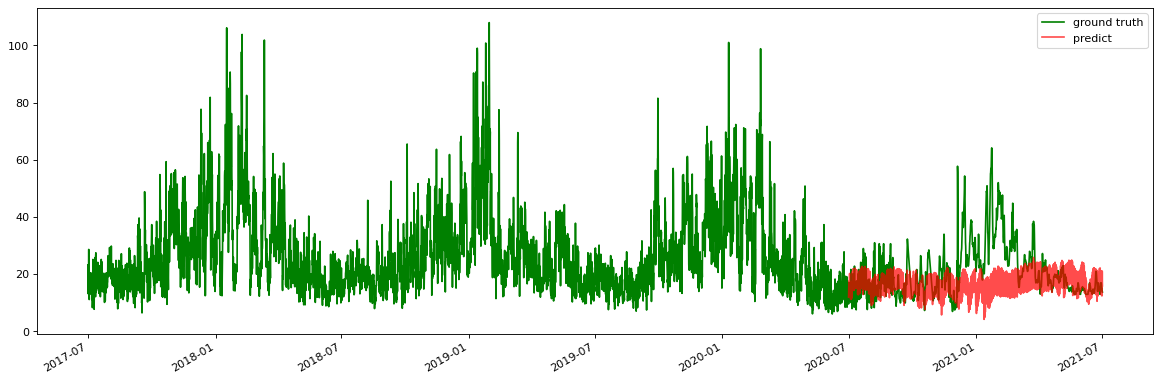

In [120]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(bkk_data['PM25'], color='g',label='ground truth')
bkk_pred.predicted_mean.plot(alpha=.7, color='r',label='predict')
plt.legend(loc="upper right")

plt.show()

# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV